In [13]:
import os
import pandas as pd
from elections.Ballot import Ballot
from elections.Candidate import Candidate
from elections.CandidateScore import CandidateScore
from elections.Party import Party  
from elections.HeadToHeadElection import HeadToHeadElection
from elections.DiversityRunoff import DiversityRunoffElection
from elections.InstantRunoffElection import InstantRunoffElection
from CVRLoader import CVRLoader
from Contest import Contest


In [14]:

def load_xlsx(directory: str) -> list[Ballot]:
    # List all XLSX files in the directory
    xlsx_files = [f for f in os.listdir(directory) if f.endswith('.xlsx') and not f.startswith('~$')]   
    
    # Declare a dictionary that maps a candidate name to a Candidate
    candidates = {}
    ballots = []
    for xlsx_file in xlsx_files:
        print(f"Processing file: '{xlsx_file}'")
        df = pd.read_excel(os.path.join(directory, xlsx_file)) 
        candidate_columns = list(range(3, len(df.columns)))
        for index, row in df.iterrows():
            scores = []
            seen = set()
            for col in candidate_columns:
                candidate_name = row.iloc[col]
                # trim anything after a ( in the candidate name.
                candidate_name = candidate_name.split('(')[0]
                # trim any leading or trailing whitespace
                candidate_name = candidate_name.strip()
                # skip if the candidate_name is "undervote" or "overvote"
                if candidate_name not in seen and candidate_name != "undervote" and candidate_name != "overvote":
                    if candidate_name not in candidates: 
                        print(f"Creating new candidate: '{candidate_name}'")
                        candidates[candidate_name] = Candidate(candidate_name, Party("None", "none"))
                    candidate = candidates[candidate_name]
                    score = 7 - col
                    scores.append(CandidateScore(candidate, score))
                    seen.add(candidate_name)
            if len(scores) > 0:
                ballots.append(Ballot(scores))

    return ballots


In [15]:
cvr_cache = {}
def load_cached_cvr(directory: str) -> CVRLoader:
    if directory not in cvr_cache:
        print(f"Loading CVR from {directory}")
        cvr_cache[directory] = CVRLoader(directory)
    return cvr_cache[directory]

csv_cache = {}
def load_cached_csv(directory: str) -> Contest:
    if directory not in csv_cache:
        print(f"Loading xlsx from {directory}")
        csv_cache[directory] = load_xlsx(directory)
    return csv_cache[directory]     

In [16]:
from elections.ElectionResult import ElectionResult
from elections.InstantRunoffElection import InstantRunoffElection, InstantRunoffResult
from elections.HeadToHeadElection import HeadToHeadElection, HeadToHeadResult
from elections.Ballot import Ballot
from elections.Candidate import Candidate
from elections.Party import Party
from elections.Party import NoParty

class CandidateSupport:
    def __init__(self, candidate: str, diversity_thresold: float, total_votes: int):
        self.candidate = candidate
        self.diversity_threshold = diversity_thresold
        self.total_votes = total_votes
        self.ballot_orders = []
        self.votes = 0
        self.diversity_of_support = 0

    def add_ballot_order(self, order: str, votes: int):
        self.ballot_orders.append((order, votes))
        self.diversity_of_support += 1 if votes / self.total_votes > self.diversity_threshold else 0
        self.votes += votes
        # print(f"Adding {order:40s} to {self.candidate:20s} with {votes:6d} votes, {votes/self.total_votes * 100:5.2f}% diversity {self.diversity_of_support}")
     

    def print(self, total_votes: int):
        print(f"Ballot Orders for {self.candidate:30s} diversity_of_support: {self.diversity_of_support}")
        # sort the ballot orders by the number of votes
        self.ballot_orders = sorted(self.ballot_orders, key=lambda x: x[1], reverse=True)
        for order, votes in self.ballot_orders:
            percentage = (votes / total_votes) * 100
            print(f"\t{order:70} {votes:7d} {percentage:5.2f}%")
        print("")

    def __lt__(self, other):     
        # print(f"compparing {self.candidate:20s} to {other.candidate:20s} with {self.diversity_of_support} and {other.diversity_of_support}")
        if self.diversity_of_support != other.diversity_of_support:
            return self.diversity_of_support < other.diversity_of_support
        return self.votes < other.votes

class SinglePeakedElection:
    def __init__(self, election_name: str, ballots: list[Ballot], thresholds: list[int], n_top_candidates: int, borda_pct: float):
        self.election_name = election_name
        self.ballots = ballots
        self.thresholds = thresholds
        self.n_top_candidates = n_top_candidates
        self.borda_pct = borda_pct 
        # the top_n candidates by borda count.  
        top_candidates = self.find_top_candidates(n_top_candidates, borda_pct)
        if len(top_candidates) < 3:
            self.single_peaked_valid = False
            self.condorcet_result = ElectionResult([])
            self.irv_result = ElectionResult([])
            self.exhausted_ballots_pct = 0
            self.extra_irv_rankings = 0
            self.diversity_results = {}
            for diversity_threshold in thresholds:
                self.diversity_results[diversity_threshold] = ElectionResult([])
            self.central_last_place_votes = 0
            self.single_peaked_min_candidate = "none"
            self.bullet_votes = 0
            self.single_peaked_votes = 1e-10
            self.single_peaked_valid = False
            self.candidtes = set()
            return

        self.condorcet_result = self.compute_condorcet_result(self.find_all_candidates())
        self.irv_result = self.compute_irv_result(self.find_all_candidates())
        self.exhausted_ballots = self.compute_irv_exhausted_ballots()
        self.extra_irv_rankings = self.compute_extra_irv_rankings()
        self.candidates = self.find_top_candidates(n_top_candidates, borda_pct)
        self.ballot_orders = self.compute_ballot_orders(self.candidates)

        self.compute_last_place_votes()


        self.diversity_results = {}
        for diversity_threshold in thresholds:
            self.diversity_results[diversity_threshold] = self.single_peaked_runoff(top_candidates, diversity_threshold) 

        self.single_peaked_min_candidate = "none"
        self.bullet_votes = 0
        self.single_peaked_votes = 1e-10
        self.compute_single_peaked_stats(self.sorted_last_place_votes[0][0])
        self.single_peaked_valid = True

    def find_all_candidates(self) -> set[Candidate]:
        candidates = set()
        for ballot in self.ballots:
            for score in ballot.ordered_candidates:
                candidates.add(score.candidate)
        return candidates

    def find_all_candidate_names(self) -> set[str]:
        candidates = self.find_all_candidates()
        return {candidate.name for candidate in candidates}

    def find_top_candidates(self, top_n: int, pct: float) -> set[str]:
        candidates = self.find_all_candidate_names()
        borda_counts = {c: 0 for c in candidates}

        for ballot in self.ballots:
            for score in ballot.ordered_candidates:
                borda_counts[score.candidate.name] += score.score

        top_candidates = sorted(borda_counts.items(), key=lambda x: x[1], reverse=True)[:top_n]

        while len(top_candidates) > 1:
            last_place_pct = top_candidates[-1][1] / top_candidates[0][1]
            if last_place_pct < pct:
                top_candidates = top_candidates[:-1]
            else:
                break

        return set(list(zip(*top_candidates))[0])

    def compute_ballot_orders(self, active_candidates: set[str]) -> dict:
        ballot_orders = {}
        for ballot in self.ballots:
            names = [score.candidate.name for score in ballot.ordered_candidates if score.candidate.name in active_candidates]
            if len(names) == len(active_candidates) - 1:
                names.append(list(active_candidates.difference(names))[0])
            if len(names) == 0:
                continue
            order = ";".join(names)
            ballot_orders[order] = ballot_orders.get(order, 0) + 1
        return ballot_orders

    def compute_condorcet_result(self, active_candidates: set[Candidate]) -> HeadToHeadResult:
        condorcet = HeadToHeadElection(self.ballots, active_candidates )
        return condorcet.result()

    def compute_irv_result(self, active_candidates: set[Candidate]) -> InstantRunoffResult:
        irv = InstantRunoffElection(self.ballots, active_candidates)
        return irv.result()


    def compute_last_place_votes(self) -> str:
        last_place_votes = {c: 0 for c in self.candidates}
        for candidate_order, votes in self.ballot_orders.items():
            candidate_names = [c for c in candidate_order.split(";")]
            if len(candidate_names) == 3:
                last_place_candidate = candidate_names[-1]
                last_place_votes[last_place_candidate] = last_place_votes.get(last_place_candidate, 0) + votes
        
        sorted_last_place_votes = sorted(last_place_votes.items(), key=lambda x: x[1], reverse=False)   

        self.last_place_votes = last_place_votes
        self.sorted_last_place_votes = sorted_last_place_votes


    def compute_single_peaked_stats(self, central_candidate: str) -> str:
        self.central_last_place_votes = self.last_place_votes[central_candidate]
        self.implied_central_candidate = central_candidate

        # find the implied partisan candidates
        # ipa has more NSP (irrational) votes than ipb
        other_candidates = list(self.candidates.difference({central_candidate}))
        ipa = other_candidates[0]
        ipb = other_candidates[1]
        if self.ballot_orders.get(f"{central_candidate};{ipa};{ipb}", 0) > self.ballot_orders.get(f"{central_candidate};{ipb};{ipa}", 0):
            self.icc_support_1 = self.ballot_orders.get(f"{central_candidate};{ipa};{ipb}", 0)
            self.icc_support_2 = self.ballot_orders.get(f"{central_candidate};{ipb};{ipa}", 0)
        else:
            self.icc_support_1 = self.ballot_orders.get(f"{central_candidate};{ipb};{ipa}", 0)
            self.icc_support_2 = self.ballot_orders.get(f"{central_candidate};{ipa};{ipb}", 0)


        nspk_a = f"{ipa};{ipb};{central_candidate}"
        nspk_b = f"{ipb};{ipa};{central_candidate}"
        if self.ballot_orders.get(nspk_a, 0) > self.ballot_orders.get(nspk_b, 0): 
            self.implied_partisan_1 = ipa
            self.implied_partisan_2 = ipb
            self.p1_nsp_votes = self.ballot_orders.get(nspk_a, 0)
            self.p2_nsp_votes = self.ballot_orders.get(nspk_b, 0)
            self.p1_last_place_votes = self.last_place_votes[ipa]
            self.p2_last_place_votes = self.last_place_votes[ipb]
        else:
            self.implied_partisan_1 = ipb
            self.implied_partisan_2 = ipa
            self.p1_nsp_votes = self.ballot_orders.get(nspk_b, 0)
            self.p2_nsp_votes = self.ballot_orders.get(nspk_a, 0)
            self.p1_last_place_votes = self.last_place_votes[ipb]
            self.p2_last_place_votes = self.last_place_votes[ipa]


        self.bullet_votes = sum([votes for order, votes in self.ballot_orders.items() if len(order.split(";")) == 1]) 
        self.single_peaked_votes = sum(self.ballot_orders.values())
        self.single_peaked_valid = True

        cw = self.condorcet_result.winner().name

        # find the candidates that are not the condorcet winner, cal
        non_cw = list(self.candidates - {cw})


        # find the number of third ballot orders that the condorcet winner has over the non-cw candidates 
        c1 = non_cw[0]
        c2 = non_cw[1]
        cw_dvotes = min(self.ballot_orders.get(f"{cw};{c1};{c2}", 0), self.ballot_orders.get(f"{cw};{c2};{c1}", 0))
        c1_dvotes = min(self.ballot_orders.get(f"{c1};{cw};{c2}", 0), self.ballot_orders.get(f"{c1};{c2};{cw}", 0))
        c2_dvotes = min(self.ballot_orders.get(f"{c2};{cw};{c1}", 0), self.ballot_orders.get(f"{c2};{c1};{cw}", 0))
        self.cw_margin = cw_dvotes - min(c1_dvotes, c2_dvotes)
        self.cw_margin_2 = cw_dvotes - max(c1_dvotes, c2_dvotes)




    def single_peaked_runoff(self, active_candidates: set[str], diversity_threshold: float) -> ElectionResult:
        ballot_orders = self.compute_ballot_orders(active_candidates)
        total_votes = sum(ballot_orders.values()) 
        # print the ballot orders for each leading candidate.  
        candidate_support = {}
        for candidates, votes in ballot_orders.items():
            candidate = candidates.split(";")[0]
            if candidate not in candidate_support:
                candidate_support[candidate] = CandidateSupport(candidate, diversity_threshold, total_votes)
            candidate_support[candidate].add_ballot_order(candidates, votes)

        
        # sort the candidates by the diversity of their support and then by the number of votes.
        # the diversity of support is the number of unique ballot orders above a threshold percentage of the total votes.
        sorted_candidates: list[CandidateSupport] = sorted(candidate_support.values(), reverse=True)
        # print("ballot orders")
        # for candidate in sorted_candidates:
        #     candidate.print(total_votes)

        # if the leaders has a majority of the votes, then they are the winner.
        if sorted_candidates[0].votes / total_votes > .5:
            if sorted_candidates[0].candidate != self.condorcet_result.winner().name:
                print(f"Mismatch:  {self.election_name:20s} Condorcet Winner: {self.condorcet_result.winner().name:30s} Diversity Winner: {sorted_candidates[0].candidate:30s}")
                print("Condorcet Results")
                self.condorcet_result.print_matrix()
                print(f"diversity_threshold: {diversity_threshold * 100:5.1f}%, n_candidates: {self.n_top_candidates:2d}")
                self.print_ballot_orders()


            return ElectionResult([Candidate(sorted_candidates[0].candidate, NoParty)])
        # otherwise remove the last place candidates from the active candidates and call the runoff again.
        last_place_candidate = sorted_candidates[-1].candidate
        return self.single_peaked_runoff(active_candidates - {last_place_candidate}, diversity_threshold)


    def compute_irv_exhausted_ballots(self) -> float:
        first_round_votes = self.irv_result.rounds[0].total_votes
        last_round_votes = self.irv_result.rounds[-1].total_votes
        return (first_round_votes - last_round_votes) 

    def compute_extra_irv_rankings(self) -> int:
        final_candidates = self.irv_result.rounds[-1].vote_totals.keys()
        extra_rankings = 0
        for ballot in self.ballots:
            # find the first candidate in the final_candidates list and its index
            for i, score in enumerate(ballot.ordered_candidates):
                if score.candidate in final_candidates:
                    if (i < len(final_candidates) - 1):
                        extra_rankings += 1
        return extra_rankings

    def print_ballot_orders(self):
        ballot_orders = self.compute_ballot_orders(self.find_top_candidates(self.n_top_candidates, self.borda_pct)) 
        total_votes = sum(ballot_orders.values())
        for order, votes in sorted(ballot_orders.items(), key=lambda x: x[0], reverse=False):
            percentage = (votes / total_votes) * 100
            print(f"{order:70} {votes:7d} {percentage:5.2f}%")

    def print_long_summary(self):
        self.print_summary()
        self.print_ballot_orders()
        self.condorcet_result.print_matrix()
        print("")

    def headings(self):
        return [
            "Election Name",
            "Total Votes",
            "Condorcet Winner",
            # "Condorcet Margin",
            # "Condorcet Margin 2",

            "Diversity Winner",

            "Central Candidate",
            "Primary Support",
            "Secondary Support",
            "Last Place Votes",

            "Partisan 1",
            "P1 NSP",

            "Partisan 2",
            "P2 NSP",

            "Bullet votes",
            "Exhausted"
        ]

    def data(self):
        return [
            self.election_name,
            self.single_peaked_votes,
            self.condorcet_result.winner().name,
            # self.cw_margin / self.single_peaked_votes,
            # self.cw_margin_2 / self.single_peaked_votes,
            self.diversity_results[.05].winner().name,

            self.implied_central_candidate,
            self.icc_support_1 / self.single_peaked_votes,
            self.icc_support_2 / self.single_peaked_votes,
            self.central_last_place_votes / self.single_peaked_votes,

            self.implied_partisan_1,
            self.p1_nsp_votes / self.single_peaked_votes,

            self.implied_partisan_2,
            self.p2_nsp_votes / self.single_peaked_votes,

            self.bullet_votes / self.single_peaked_votes,
            self.exhausted_ballots
        ]

    def print_header(self):
        print(f"{'Election Name':32s}", end="\t")
        print(f"{'Total Votes':10s}", end="\t")

        print(f"{'Central Candidate':30s}", end="\t")
        print(f"{'Primary Support':16s}", end="\t")
        print(f"{'Secondary Support':16s}", end="\t")
        print(f"{'Last Place Votes':12s}", end="\t")

        print(f"{'Partisan 1':30s}", end="\t")
        print(f"{'P1 NSP':6s}", end="\t")

        print(f"{'Partisan 2':30s}", end="\t")
        print(f"{'P2 NSP':6s}", end="\t")
        
        print(f"{'Bullet votes':12s}", end="\t")
        print(f"{'Exhausted':12s}")


    def print_summary(self):
        print(f"{self.election_name:32s}", end="\t")
        print(f"{self.single_peaked_votes:10d}", end="\t")

        print(f"{self.implied_central_candidate:30s}", end="\t")
        print(f"{self.icc_support_1 / self.single_peaked_votes:6.4f}", end="\t")
        print(f"{self.icc_support_2 / self.single_peaked_votes:6.4f}", end="\t")    
        print(f"{self.central_last_place_votes / self.single_peaked_votes:9.4f}", end="\t")

        print(f"{self.implied_partisan_1:30s}", end="\t")
        print(f"{self.p1_nsp_votes / self.single_peaked_votes:6.4f}", end="\t")

        print(f"{self.implied_partisan_2:30s}", end="\t")
        print(f"{self.p2_nsp_votes / self.single_peaked_votes:6.4f}", end="\t")

        print(f"{self.bullet_votes / self.single_peaked_votes:11.4f}", end="\t")
        print(f"{self.exhausted_ballots / len(self.ballots):11.2f}")


def analyze_single_peaked_elections(n_top_candidates=3, borda_pct=.01) -> dict[str, list[SinglePeakedElection]]:
    results_by_path: dict[str, list[SinglePeakedElection]] = {}
    thresholds = [.050, .051, .052, .053, .054, .055, .056, .057, .058, .059, .060]
    for path in ["mainedata/2018/house-2", "mainedata/2022/house-2", "mainedata/2024/house-2"]:
        if True:
            ballots = load_cached_csv(path)
            single_peaked_election = SinglePeakedElection(path, ballots, thresholds, n_top_candidates, borda_pct)
            if single_peaked_election.single_peaked_valid:
                results_by_path[path] = [single_peaked_election]


    base_dir = "AlaskaData"
    for dir in [f for f in os.listdir(base_dir) if f.startswith("CVR")]:
        cvr = load_cached_cvr(os.path.join(base_dir, dir))
        print(f"{dir}: Loaded {len(cvr.elections)} elections")
        results_by_path[dir] = []

        for contest in cvr.elections.values():
            if contest.number_of_ranks < 3:
                continue
            single_peaked_election = SinglePeakedElection(contest.name, contest.ballots, thresholds, n_top_candidates, borda_pct)
            if single_peaked_election.single_peaked_valid:
                results_by_path[dir].append(single_peaked_election)
    

    for diversity_threshold in thresholds:
        condocet_mismatches = 0
        n_elections = 0
        for path, result_list in results_by_path.items():
            for results in result_list:
                n_elections += 1
                if results.diversity_results[diversity_threshold].winner().name != results.condorcet_result.winner().name:
                    condocet_mismatches += 1
                    print(f"Contest: {results.election_name} Diversity Threshold: {diversity_threshold * 100:5.2f}% " + 
                          f" Condorcet Winner: {results.condorcet_result.winner().name:30s} " + 
                          f" Diversity Winner: {results.diversity_results[diversity_threshold].winner().name:30s}")
        print(f"diversity_threshold: {diversity_threshold * 100:5.1f}% n_elections {n_elections:3d} condorcet_mismatches: {condocet_mismatches:2d}")
    
    return results_by_path

from contextlib import redirect_stdout
results_by_path_list = []
for n_top_candidates, borda_pct in [[3, .2], [3, .01], [5,.001]]:
    with open(f"da-{n_top_candidates:02d}-{borda_pct:.2f}.txt", "w") as f:
        with redirect_stdout(f):
            r = analyze_single_peaked_elections(n_top_candidates, borda_pct)
            results_by_path_list.append (r)



/Users/robbie/work/sf/.venv/lib/python3.9/site-packages/openpyxl/reader/workbook.py:118: UserWarning: Print area cannot be set to Defined name: 'Rep. to Congress District 2'!$D:$H.
  warn(f"Print area cannot be set to Defined name: {defn.value}.")


In [17]:
def print_ballot_orders(path: str, results_by_path: dict[str, list[SinglePeakedElection]]):
    with open(path, "w") as f:
        with redirect_stdout(f):
            for path, result_list in results_by_path.items():
                for spe in result_list:
                    print(f"Ballot Orders for {spe.election_name:30s}")
                    spe.print_ballot_orders()
                    print("")
print_ballot_orders("three_candidate_ballot_orders.txt", results_by_path_list[0])    
print_ballot_orders("all_ballot_orders.txt", results_by_path_list[-1])    

In [18]:
def construct_df(results_by_path: dict[str, list[SinglePeakedElection]]) -> pd.DataFrame:
    data = []
    for path, result_list in results_by_path.items():
        for results in result_list:
            data.append(results.data())
    return pd.DataFrame(data, columns=results.headings())

df = construct_df(results_by_path_list[0])

In [19]:
df_all = construct_df(results_by_path_list[1])
df_all 


,Election Name,Total Votes,Condorcet Winner,Diversity Winner,Central Candidate,Primary Support,Secondary Support,Last Place Votes,Partisan 1,P1 NSP,Partisan 2,P2 NSP,Bullet votes,Exhausted
0,mainedata/2018/house-2,287969,"DEM Golden, Jared F.","DEM Golden, Jared F.","Bond, Tiffany L.",0.032236,0.013762,0.078988,"REP Poliquin, Bruce",0.043275,"DEM Golden, Jared F.",0.035712,0.534856,8247
1,mainedata/2022/house-2,317044,"Golden, Jared Forrest","Golden, Jared Forrest","Bond, Tiffany",0.038064,0.015424,0.065615,"Poliquin, Bruce",0.037351,"Golden, Jared Forrest",0.028264,0.498309,5216
2,mainedata/2024/house-2,393241,"Golden, Jared Forrest","Golden, Jared Forrest","Golden, Jared Forrest",0.085462,0.010988,0.007316,"Theriault, Austin",0.006838,Write-in,0.000478,0.839450,1266
3,U.S. President / Vice President,335722,Trump/Vance,Trump/Vance,Kennedy/Shanahan,0.008269,0.006136,0.029492,Trump/Vance,0.014929,Harris/Walz,0.014563,0.760358,4584
4,U.S. Representative,332160,"Begich, Nick","Begich, Nick","Howe, John Wayne",0.014984,0.008469,0.061633,"Peltola, Mary S.",0.040336,"Begich, Nick",0.021297,0.727047,8244
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,House District 23,7273,"Allard, Jamie","Allard, Jamie","Branson, Roger L.",0.117696,0.007700,0.005225,"Allard, Jamie",0.004537,Write-in,0.000687,0.632476,86
96,House District 17,5436,"Fields, William Z. ""Zack""","Fields, William Z. ""Zack""","Drummond, Harriet A.",0.214128,0.001840,0.003127,"Fields, William Z. ""Zack""",0.002208,Write-in,0.000920,0.488411,118
97,House District 14,5708,"Galvin, Alyse S.","Galvin, Alyse S.","Galvin, Alyse S.",0.153819,0.008935,0.005256,"Danger, Nicholas",0.004380,Write-in,0.000876,0.771549,18
98,House District 32,3168,"Stapp, Will B.","Stapp, Will B.","Stapp, Will B.",0.287247,0.031881,0.041351,"Lawrence, Van",0.038826,"Givens, Timothy W.",0.002525,0.446023,155


In [20]:
df.to_excel('results.xlsx', index=False)
df_all.to_excel('results_all.xlsx', index=False)
df.to_csv('results.csv', index=False)
df_all.to_csv('results_all.csv', index=False)

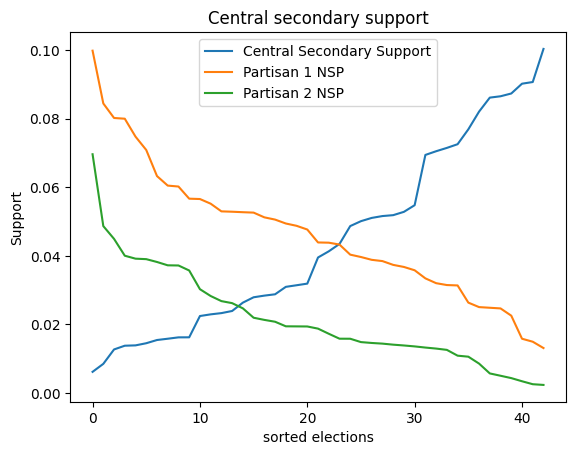

In [21]:
import matplotlib.pyplot as plt

# Extract the Secondary Support column and sort it
secondary_support = df['Secondary Support'].sort_values()
partisan_1 = df['P1 NSP'].sort_values(ascending=False)
partisan_2 = df['P2 NSP'].sort_values(ascending=False)

# Plot the sorted Secondary Support as a line plot
plt.plot(secondary_support.values, label='Central Secondary Support')
plt.plot(partisan_1.values, label='Partisan 1 NSP')
plt.plot(partisan_2.values, label='Partisan 2 NSP')

plt.xlabel('sorted elections')
plt.ylabel('Support')
plt.title('Central secondary support')
plt.legend()
plt.show()

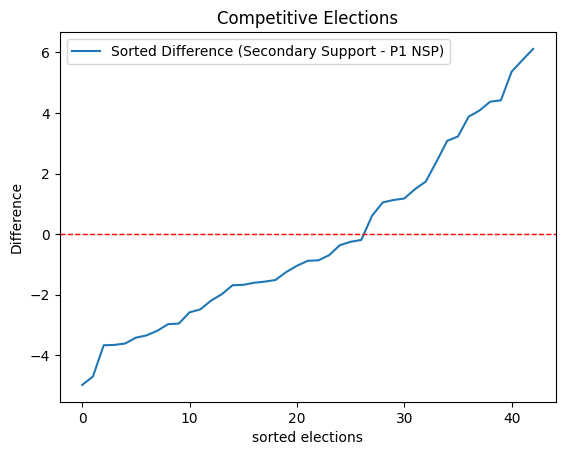

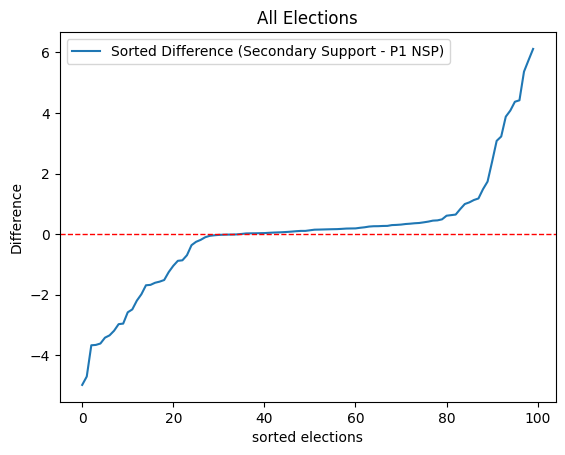

In [22]:
def plot_sorted_difference(df: pd.DataFrame, title: str):
    import matplotlib.pyplot as plt
    
    # Calculate the difference between Secondary Support and P1 NSP
    difference = (df['Secondary Support'] - df['P1 NSP']) * 100

    # Sort the differences
    sorted_difference = difference.sort_values()

    # Plot the sorted differences
    plt.plot(sorted_difference.values, label='Sorted Difference (Secondary Support - P1 NSP)')

    # Add a horizontal line at y=0
    plt.axhline(0, color='red', linestyle='--', linewidth=1)

    plt.xlabel('sorted elections')
    plt.ylabel('Difference')
    plt.title(title)
    plt.legend()
    plt.show()

# Example usage:
plot_sorted_difference(df, 'Competitive Elections')
plot_sorted_difference(df_all, 'All Elections')

In [23]:
df_mismatch = df_all[df_all['Condorcet Winner'] != df_all['Diversity Winner']]
df_mismatch

,Election Name,Total Votes,Condorcet Winner,Diversity Winner,Central Candidate,Primary Support,Secondary Support,Last Place Votes,Partisan 1,P1 NSP,Partisan 2,P2 NSP,Bullet votes,Exhausted


In [24]:
# Extract the Condorcet Margin column and sort it
# condorcet_margin = df['Condorcet Margin'].sort_values()
# condorcet_margin_2 = df['Condorcet Margin 2'].sort_values()

# Plot the sorted Condorcet Margin as a line plot
# plt.plot(condorcet_margin.values, label='Condorcet Margin')
# plt.plot(condorcet_margin_2.values, label='Condorcet Margin 2')

# Add a horizontal line at y=0
# plt.axhline(0, color='red', linestyle='--', linewidth=1)

# plt.xlabel('sorted elections')
# plt.ylabel('Condorcet Margin')
# plt.title('Condorcet Vote Margin Sorted')
# plt.legend()
# plt.show()